In [60]:
%%capture
!pip install datasets transformers

In [61]:
%%capture
!pip install huggingface_hub

In [62]:
from datasets import load_dataset, load_metric
from huggingface_hub import login
from huggingface_hub import HfApi
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image
import torch
import numpy as np

In [ ]:
# Logueo con mi cuenta de Hugging Face
login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
# Utilizo la api de hugging face para hacer un push del dataset
"""
api = HfApi()
api.upload_folder(
    folder_path="/content/drive/MyDrive/ggal_agro_files_change/dataset_riego",
    path_in_repo="dataset_riego",
    repo_id="MaxP/agro_riego",
    repo_type="dataset",
    ignore_patterns="**/logs/*.txt"
)
"""

'https://huggingface.co/datasets/MaxP/agro_riego/tree/main/dataset_riego'

### Pitfall importante cargar el dataset como un archivo tipo .zip reduce los tiempos de carga sustancialmente

In [63]:
train_ds = load_dataset('MaxP/agro_riego')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/MaxP___imagefolder/MaxP--agro_riego-3092de82d23e5d10/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

### Muestro algunas imagenes random

In [65]:
train_ds = train_ds.rename_column("label", "labels")

In [67]:
def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

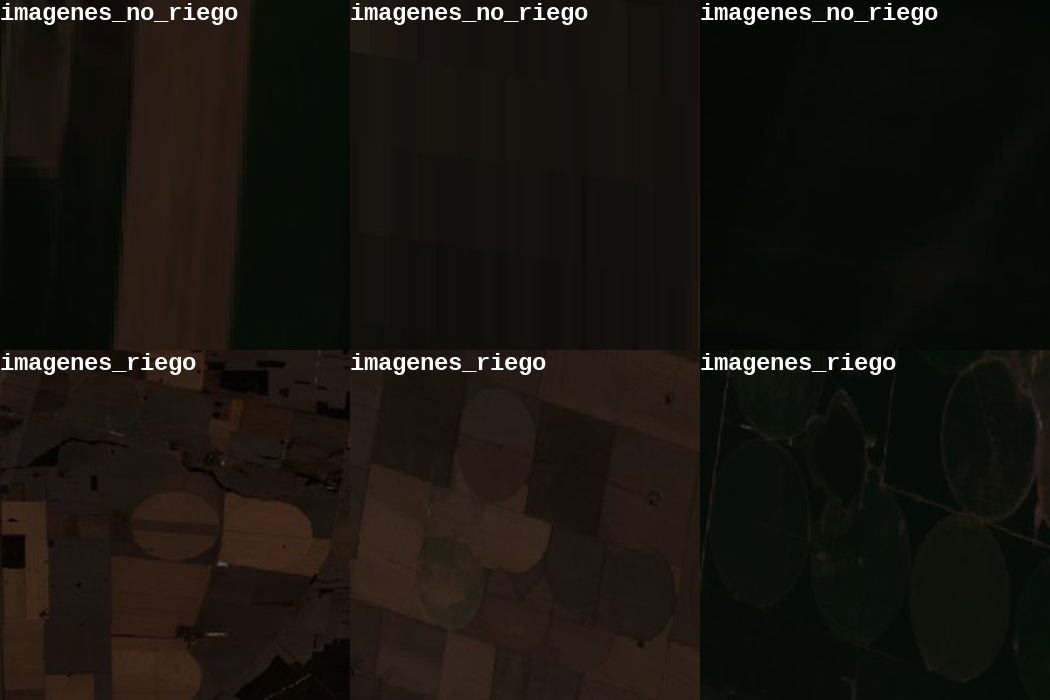

In [68]:
show_examples(train_ds, seed=random.randint(0, 1300), examples_per_class=3)

### Una vez que tenemos el dataset cargado, lo que necesitamos es definir las transformaciones que vamos a hacerle a los datos para alimentar el modelo

Por lo general, se utiliza un feature extractor del modelo pre-entrenado el cual queremos usar, en este caso vamos a usar el modelo desarrollado por google 'google/vit-base-patch16-224-in21k' por lo cual vamos a utilizar el objeto feature extractor que disponibilizaron para este modelo.

In [69]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

### El siguiente paso es procesar todo el dataset con el objeto Feature Extractor

In [70]:
# Definimos la funcion transform que lo que hace es recibe un batch de imagenes y labels
# Luego procesa cada una y devuelve este batch procesado
# El proceso se realiza en batch para no ocupar demasiado espacio en memoria
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [71]:
# Una vez definida la funcion vamos a realizar estas transformaciones a todo el dataset
prepared_ds = train_ds.with_transform(transform)

## Training and Evaluation

Tenemos que preparar los datos haciendo un par de tareas

1. Definir una funcion de "collate" para procesar los batchs
2. Definir una metrica de evaluacion, en nuestro caso como es un problema de clasificacion vamos a usar el F1-Score
3. Definir la configuracion de entrenamiento
4. Evaluar los resultados


In [72]:
# Defino la funcion collate
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [73]:
# Defino la metrica y la funcion para calcular esta metrica
metric = load_metric("f1")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [74]:
from transformers import ViTForImageClassification

labels = prepared_ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [107]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./output/vit-base-riego",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=3,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

PyTorch: setting up devices


In [108]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)

Cloning https://huggingface.co/MaxP/vit-base-riego into local empty directory.
Using cuda_amp half precision backend


In [109]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3360
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 630
  Number of trainable parameters = 85800194


Step,Training Loss,Validation Loss,F1
100,0.044300,0.473735,0.874206
200,0.034900,0.077426,0.973294
300,0.003000,0.067511,0.979412
400,0.002000,0.067426,0.980966
500,0.001400,0.043110,0.987088
600,0.001100,0.054410,0.985380


***** Running Evaluation *****
  Num examples = 840
  Batch size = 8
Saving model checkpoint to ./output/vit-base-riego/checkpoint-100
Configuration saved in ./output/vit-base-riego/checkpoint-100/config.json
Model weights saved in ./output/vit-base-riego/checkpoint-100/pytorch_model.bin
Image processor saved in ./output/vit-base-riego/checkpoint-100/preprocessor_config.json
Image processor saved in ./output/vit-base-riego/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 840
  Batch size = 8
Saving model checkpoint to ./output/vit-base-riego/checkpoint-200
Configuration saved in ./output/vit-base-riego/checkpoint-200/config.json
Model weights saved in ./output/vit-base-riego/checkpoint-200/pytorch_model.bin
Image processor saved in ./output/vit-base-riego/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 840
  Batch size = 8
Saving model checkpoint to ./output/vit-base-riego/checkpoint-300
Configuration saved in ./output/vit

Upload file pytorch_model.bin:   0%|          | 3.30k/327M [00:00<?, ?B/s]

Upload file runs/Dec30_19-12-45_99208a1bd131/events.out.tfevents.1672427575.99208a1bd131.169.5:  21%|##1      …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/MaxP/vit-base-riego
   f07993f..1ac515e  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/MaxP/vit-base-riego
   f07993f..1ac515e  main -> main

To https://huggingface.co/MaxP/vit-base-riego
   1ac515e..b42c07b  main -> main

   1ac515e..b42c07b  main -> main



***** train metrics *****
  epoch                    =         3.0
  total_flos               = 727473995GF
  train_loss               =      0.0415
  train_runtime            =  0:05:58.59
  train_samples_per_second =      28.109
  train_steps_per_second   =       1.757


In [81]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 840
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_f1                 =     0.9855
  eval_loss               =     0.0545
  eval_runtime            = 0:00:12.74
  eval_samples_per_second =     65.883
  eval_steps_per_second   =      8.235


In [ ]:
!huggingface-cli login

In [84]:
from huggingface_hub import notebook_login

In [85]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [86]:
trainer.push_to_hub(repo_name='vit-base-riego')

'google/vit-base-patch16-224-in21k'

In [110]:
trainer.save_model('/content/drive/MyDrive/ggal_agro/modelos/image_classification_riego/')

Saving model checkpoint to /content/drive/MyDrive/ggal_agro/modelos/image_classification_riego/
Configuration saved in /content/drive/MyDrive/ggal_agro/modelos/image_classification_riego/config.json
Model weights saved in /content/drive/MyDrive/ggal_agro/modelos/image_classification_riego/pytorch_model.bin
Image processor saved in /content/drive/MyDrive/ggal_agro/modelos/image_classification_riego/preprocessor_config.json
Saving model checkpoint to ./output/vit-base-riego
Configuration saved in ./output/vit-base-riego/config.json
Model weights saved in ./output/vit-base-riego/pytorch_model.bin
Image processor saved in ./output/vit-base-riego/preprocessor_config.json
To https://huggingface.co/MaxP/vit-base-riego
   b42c07b..962d458  main -> main

   b42c07b..962d458  main -> main

